In [1]:
# Clone the BARTScore repository
!git clone https://github.com/neulab/BARTScore.git

fatal: destination path 'BARTScore' already exists and is not an empty directory.


In [2]:
%cd /content/BARTScore

/content/BARTScore


In [3]:
# Import libraries
from bart_score import BARTScorer
import torch

In [4]:
# Install necessary libraries
!pip install --upgrade pip  # ensures that pip is current
!pip install tensorflow tensorflow_hub transformers
!pip install git+https://github.com/google-research/bleurt.git
!pip install pandas
!pip install groq
!pip install scikit-learn
!pip install matplotlib
!pip install nltk
!pip install rouge
!pip install sacrebleu
!pip install bert-score
!pip install rouge
# Navigate to the repository directory
%cd /content/BARTScore

# Download and unzip BLEURT checkpoint
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
!unzip BLEURT-20.zip

# Initialize BART-Scorer
bart_scorer = BARTScorer(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                         checkpoint='facebook/bart-large-cnn')

!pip install groq
!pip install sentence-transformers
!pip install chromadb
!pip install pymongo pandas
!pip install transformers torch accelerate bitsandbytes
!pip install --upgrade transformers
!pip install rouge
!pip install google-search-results
!pip install requests beautifulsoup4 lxml

  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.29.0 requires protobuf<6.0,>=5.0, but you have protobuf 4.25.5 which is incompatible.
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-rgk4nrny
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-rgk4nrny
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
/content/BARTScore
--2025-01-17 21:54:40--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.3 which is incompatible.


In [5]:
import traceback
import requests
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
import random
import nltk
from groq import Groq
import pandas as pd
import signal
import time
import re
from sentence_transformers import SentenceTransformer

import tensorflow as tf
import tensorflow_hub as hub
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sacrebleu.metrics import CHRF, TER
from bert_score import score
from bleurt import score as bleurt_score
import json
import random
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Suppress specific warning messages
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
# Function to read and combine datasets
def load_and_combine_datasets(file_paths):
    combined_claims = []
    for file_path in file_paths:
        try:
            data = pd.read_json(file_path)
            combined_claims.extend(data.to_dict(orient='records'))
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    random.shuffle(combined_claims)  # Shuffle claims for randomness
    return pd.DataFrame(combined_claims)

# File paths for datasets
file_paths = ["/content/last_fake_claims.json", "/content/Modified_true_claims.json"]

# Load and combine datasets
df = load_and_combine_datasets(file_paths)

# Initialize the SentenceTransformer model
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Initialize the Groq API client with the first API key
api_key = "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"
client = Groq(api_key=api_key)

# Label map
label_map = {'true': 'true', 'fake': 'fake', "correct": "true", "false": "fake", "incorrect": "fake", "not true": "fake", "**true**": "true", "**false**": "fake"}

# Function to extract content from a URL (Assumes supporting document is a URL)
def extract_content_from_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            paragraphs = soup.find_all('p')
            content = " ".join([para.get_text() for para in paragraphs])
            return content
        else:
            print(f"Failed to retrieve URL: {url}")
            return ""
    except Exception as e:
        print(f"Error fetching content from URL {url}: {e}")
        return ""

# Function to extract relevant sentences based on semantic similarity using SentenceTransformer
def extract_relevant_context(claim, content, max_sentences=5):
    # Tokenize the content into sentences
    sentences = nltk.sent_tokenize(content)
    if not sentences:
        return content  # If no sentences, return the full content

    # Generate sentence embeddings for the claim and the content sentences
    claim_embedding = sentence_model.encode([claim])[0]
    content_embeddings = sentence_model.encode(sentences)

    # Compute cosine similarity between the claim and each sentence
    cosine_similarities = cosine_similarity([claim_embedding], content_embeddings).flatten()

    # Get the indices of the top relevant sentences
    top_indices = cosine_similarities.argsort()[-max_sentences:][::-1]
    relevant_sentences = [re.sub(r'\s+', ' ', sentences[i]) for i in top_indices]

    # Return the combined relevant sentences
    return ' '.join(relevant_sentences)

class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Set the timeout handler
signal.signal(signal.SIGALRM, timeout_handler)

def get_claim_predictions(claim, supporting_document, timeout=120, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            # Set the alarm for the timeout
            signal.alarm(timeout)

            # Use the supporting document directly
            context = supporting_document
            if not context:
                print(f"No content available for the supporting document for claim: {claim}")
                return ("", "", supporting_document)

            # Extract relevant context from supporting document
            refined_context = extract_relevant_context(claim, context)
            print(f"Refined context: {refined_context[:1000]}...")  # Print first 1000 chars for preview

            prompt = f"Label the following claim as 'true' or 'fake' from the given context. Answer with either 'TRUE' or 'FAKE' only in the first line. Also add another line for justification from the given context only. Context: {refined_context} . Claim:{claim}"
            print(f"Input token length: {len(prompt.split())}")

            # Call the model with the prompt
            chat_completion = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model="llama-3.3-70b-versatile",
                max_tokens=8000,
            )

            # Get the classification result from the model
            predicted_result = chat_completion.choices[0].message.content.splitlines()
            print(predicted_result)
            predicted_label = re.sub(r'[^a-zA-Z]+', '', predicted_result[0]).lower()
            predicted_label = label_map.get(predicted_label, "unknown")
            predicted_justification = " ".join(predicted_result[1:]).strip().lower()

            # Cancel the alarm if the function completes in time
            signal.alarm(0)

            return (prompt, predicted_label, predicted_justification)

        except TimeoutException:
            print(f"Timeout occurred for claim: {claim}, attempt {attempt + 1}")
            attempt += 1
            if attempt < retries:
                print("Retrying after 2 minutes...")
                time.sleep(30)  # Wait for 2 minutes before retrying
        except Exception as e:
            print(f"Error processing claim '{claim}': {e}")
            traceback.print_exc()
            return ("", "", supporting_document)

    return ("", "", supporting_document)

# Initialize lists for results
results = []
actual_labels = []
predicted_labels = []
predicted_justifications = []
actual_justifications = []

# Initialize counters for tracking model performance
correct_predictions = 0
n_claims = 5006  # Adjust this to the desired number of claims to process
total_processed_claims = 0

# Process each claim
for index, row in df.head(n_claims).iterrows():
    claim = row.get('claim', "").strip()
    actual_label = str(row.get('label', "").strip().lower())
    actual_justification = str(row.get('justification', "").strip().lower())
    supporting_document = row.get('supporting_document', "")

    # Skip rows with missing data
    if not claim or not actual_label or not actual_justification:
        print(f"Skipping row {index} due to missing data.")
        continue

    # Get the content of the supporting document (if it's a URL)
    if supporting_document:
        supporting_content = extract_content_from_url(supporting_document)
    else:
        supporting_content = ""

    # Call prediction function
    prompt, predicted_label, predicted_justification = get_claim_predictions(claim, supporting_content)
    total_processed_claims += 1

    if (predicted_label, predicted_justification) == ("", ""):
        continue

    # Append the actual and predicted labels to the lists
    actual_labels.append(actual_label)
    actual_justifications.append(actual_justification)
    predicted_labels.append(predicted_label)
    predicted_justifications.append(predicted_justification)

    # Compare the predicted label with the actual label
    if predicted_label == actual_label:
        correct_predictions += 1

    print(f"Claim number: {index+1}")
    print(f"Prompt: {prompt}")
    print(f"Claim: {claim}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Predicted Justification: {predicted_justification}")
    print(f"Actual Label: {actual_label}")
    print(f"Supporting Document: {supporting_document}")
    print('-' * 50)

# Calculate the overall accuracy of the model
accuracy = (correct_predictions / total_processed_claims) * 100 if total_processed_claims > 0 else 0
print(f"Model Accuracy: {accuracy:.2f}%")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Input token length: 176
['TRUE', 'The claim is justified as the context mentions a video of a burqa-clad woman being punished by policemen for allegedly pelting stones at the Ram Navami procession on April 10 in Khargone, Madhya Pradesh, which aligns with the claim.']
Claim number: 4528
Prompt: Label the following claim as 'true' or 'fake' from the given context. Answer with either 'TRUE' or 'FAKE' only in the first line. Also add another line for justification from the given context only. Context: A video of a group of policemen making a burqa-clad woman do sit-ups on the road was circulated on social media with the claim that the woman was punished for pelting stones at the Ram Navami procession on April 10 in Khargone, Madhya Pradesh. Stone-pelting took place during a Ram Navami procession in Khargone, Madhya Pradesh, on April 10, leading to communal clashes. Stone-pelting took place during a Ram Navami procession in Khargone, Madhy

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Average BLEU Score: 0.0861
Average METEOR Score: 0.3082
Average ChrF Score: 39.8266
Average TER Score: 102.4206
Average BERTScore F1: 0.8908
Average BLEURT Score: 0.5046
Average BARTScore: -2.8964
Average ROUGE-1 F1 Score: 0.3768
Average ROUGE-2 F1 Score: 0.1551
Average ROUGE-L F1 Score: 0.3181
Model Accuracy: 72.03%
F1 Score Average: 0.7721262891143956


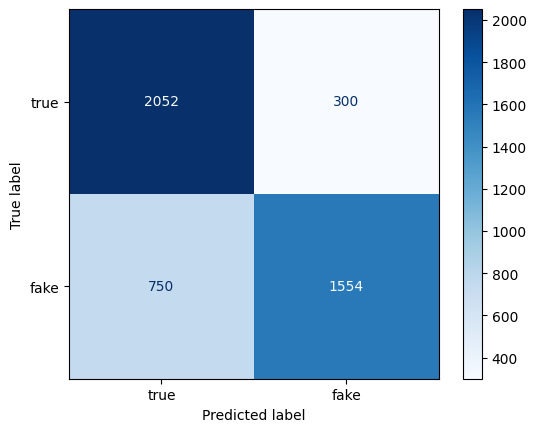

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Metrics initialization
rouge = Rouge()
smoothing_function = SmoothingFunction().method4
chrf = CHRF()
ter = TER()
bleurt_scorer = bleurt_score.BleurtScorer("BLEURT-20")

# Filter out empty justifications
filtered_justifications = [
    (actual, predicted)
    for actual, predicted in zip(actual_justifications, predicted_justifications)
    if predicted.strip()
]

# Calculate metrics
def calculate_metrics_extended(justifications):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    chrf_scores = []
    ter_scores = []
    bert_scores = []
    bleurt_scores = []
    bart_scores = []

    for ref, pred in justifications:
        # BLEU score
        bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothing_function)
        bleu_scores.append(bleu)

        # ROUGE score
        rouge_score = rouge.get_scores(pred, ref, avg=True)
        rouge_scores.append(rouge_score)

        # METEOR score
        meteor = meteor_score([ref.split()], pred.split())
        meteor_scores.append(meteor)

        # ChrF
        chrf_scores.append(chrf.corpus_score([pred], [[ref]]).score)

        # TER
        ter_scores.append(ter.corpus_score([pred], [[ref]]).score)

        # BERTScore
        P, R, F1 = score([pred], [ref], lang="en", device=device)
        bert_scores.append(F1.mean().item())

        # BLEURT
        bleurt_scores.append(bleurt_scorer.score(references=[ref], candidates=[pred])[0])

        # BARTScore
        bart_scores.append(bart_scorer.score([pred], [ref])[0])

    return bleu_scores, rouge_scores, meteor_scores, chrf_scores, ter_scores, bert_scores, bleurt_scores, bart_scores

# Calculate metrics
bleu_scores, rouge_scores, meteor_scores, chrf_scores, ter_scores, bert_scores, bleurt_scores, bart_scores = calculate_metrics_extended(filtered_justifications)

# Summarize and print results
avg_rouge_1 = sum([score['rouge-1']['f'] for score in rouge_scores]) / len(rouge_scores)
avg_rouge_2 = sum([score['rouge-2']['f'] for score in rouge_scores]) / len(rouge_scores)
avg_rouge_l = sum([score['rouge-l']['f'] for score in rouge_scores]) / len(rouge_scores)

print(f"Average BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average METEOR Score: {sum(meteor_scores) / len(meteor_scores):.4f}")
print(f"Average ChrF Score: {sum(chrf_scores) / len(chrf_scores):.4f}")
print(f"Average TER Score: {sum(ter_scores) / len(ter_scores):.4f}")
print(f"Average BERTScore F1: {sum(bert_scores) / len(bert_scores):.4f}")
print(f"Average BLEURT Score: {sum(bleurt_scores) / len(bleurt_scores):.4f}")
print(f"Average BARTScore: {sum(bart_scores) / len(bart_scores):.4f}")
print(f"Average ROUGE-1 F1 Score: {avg_rouge_1:.4f}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge_2:.4f}")
print(f"Average ROUGE-L F1 Score: {avg_rouge_l:.4f}")

# Calculate accuracy
accuracy = (correct_predictions / total_processed_claims) * 100 if total_processed_claims > 0 else 0
print(f"Model Accuracy: {accuracy:.2f}%")

# Calculate the F1 score
f1 = f1_score(actual_labels, predicted_labels, average='weighted', labels=["true", "fake"])
print(f"F1 Score Average: {f1}")

# Confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["true", "fake"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()